In [1]:
# Risk analysis of mag7 stocks
import yfinance as yf

risk_free_rate=0.02

stocks=['AAPL','NVDA','MSFT','GOOG','GOOGL','AMZN','META','TSLA']
data=[yf.Ticker(i).history(period="max") for i in stocks]
market_caps=[yf.Ticker(i).info['marketCap'] for i in stocks]
spx=yf.Ticker('^GSPC').history(period="max")



In [2]:
dates=[i.index[0] for i in data]
cutoff_date=max(dates)

spx=spx[spx.index>=cutoff_date]
spx['daily_return']=spx['Close'].pct_change()
spx.dropna(inplace=True)
for i in range(len(stocks)):
    data[i]=data[i][data[i].index>=cutoff_date]
    data[i]['daily_return']=data[i]['Close'].pct_change()
    data[i].dropna(inplace=True)
    


In [3]:
import numpy as np
import pandas as pd

monthly_returns=np.zeros(len(stocks))
stdevs=np.zeros(len(stocks))
betas=np.zeros(len(stocks))
treynor_ratios=np.zeros(len(stocks))
value_at_risk95=np.zeros(len(stocks))
value_at_risk99=np.zeros(len(stocks))

for i in range(len(stocks)):
    monthly_returns[i]=np.power(np.mean(data[i]['daily_return'])+1,21)-1
    stdevs[i]=np.std(data[i]['daily_return'])*np.sqrt(21)
    betas[i] = np.cov(data[i]['daily_return'],spx['daily_return'])[0,1]/np.var(spx['daily_return'])
    treynor_ratios[i]=(monthly_returns[i]-risk_free_rate)/betas[i]
    value_at_risk95[i]=monthly_returns[i]-2*stdevs[i]
    value_at_risk99[i]=monthly_returns[i]-3*stdevs[i]

df=pd.DataFrame({'Stock':stocks,'Monthly Return %':monthly_returns*100,'Standard Deviation %':stdevs*100,'Beta':betas,'Treynor%':treynor_ratios*100,'Value at Risk 95%':value_at_risk95*100,'Value at Risk 99%':value_at_risk99*100})

In [4]:
# Calculate market cap weights
weights = np.array(market_caps) / sum(market_caps)

# Calculate portfolio metrics
port_monthly_return = np.sum(monthly_returns * weights) * 100
port_std = np.sqrt(np.sum(weights**2 * stdevs**2)) * 100
port_beta = np.sum(betas * weights)
port_treynor = ((port_monthly_return/100 - risk_free_rate) / port_beta) * 100
port_var95 = (port_monthly_return/100 - 2 * port_std/100) * 100
port_var99 = (port_monthly_return/100 - 3 * port_std/100) * 100

# Add portfolio row to DataFrame
portfolio_row = pd.DataFrame({
    'Stock': ['Portfolio'],
    'Monthly Return %': [port_monthly_return],
    'Standard Deviation %': [port_std],
    'Beta': [port_beta],
    'Treynor%': [port_treynor],
    'Value at Risk 95%': [port_var95],
    'Value at Risk 99%': [port_var99]
})

df = pd.concat([df, portfolio_row], ignore_index=True)

# Add S&P 500 metrics
spx_monthly_return = (np.power(np.mean(spx['daily_return'])+1, 21)-1) * 100
spx_std = np.std(spx['daily_return']) * np.sqrt(21) * 100
spx_beta = 1.0  # By definition
spx_treynor = (spx_monthly_return/100 - risk_free_rate) * 100
spx_var95 = (spx_monthly_return/100 - 2 * spx_std/100) * 100
spx_var99 = (spx_monthly_return/100 - 3 * spx_std/100) * 100

spx_row = pd.DataFrame({
    'Stock': ['S&P 500'],
    'Monthly Return %': [spx_monthly_return],
    'Standard Deviation %': [spx_std],
    'Beta': [spx_beta],
    'Treynor%': [spx_treynor],
    'Value at Risk 95%': [spx_var95],
    'Value at Risk 99%': [spx_var99]
})

df = pd.concat([df, spx_row], ignore_index=True)
df

,Stock,Monthly Return %,Standard Deviation %,Beta,Treynor%,Value at Risk 95%,Value at Risk 99%
0,AAPL,2.124284,8.080615,1.161068,0.107043,-14.036947,-22.117562
1,NVDA,5.043961,12.964899,1.680814,1.811004,-20.885838,-33.850738
2,MSFT,2.211459,7.536771,1.192953,0.177257,-12.862084,-20.398855
3,GOOG,2.020734,7.848631,1.135706,0.018256,-13.676528,-21.525159
4,GOOGL,2.012965,7.842515,1.137648,0.011397,-13.672064,-21.514579
5,AMZN,2.445677,9.240613,1.166421,0.382090,-16.035548,-25.276161
6,META,2.529677,11.499699,1.243322,0.426018,-20.469720,-31.969419
7,TSLA,5.003544,16.480216,1.496190,2.007462,-27.956888,-44.437104
8,Portfolio,2.853114,3.609190,1.275716,0.668733,-4.365266,-7.974455
9,S&P 500,1.116597,4.834730,1.000000,-0.883403,-8.552863,-13.387593


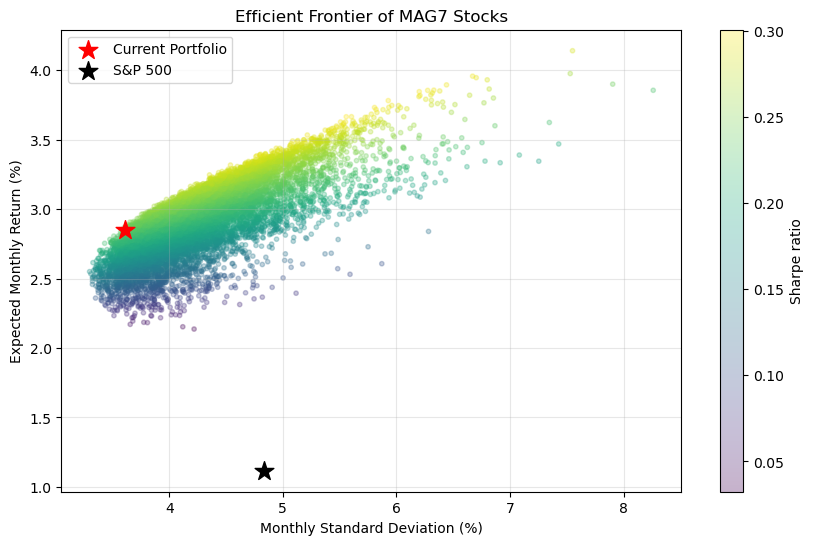

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Monte Carlo simulation for portfolio optimization
n_portfolios = 10000
results = np.zeros((n_portfolios, 3))  # Return, StDev, Sharpe Ratio

weights_list = []
for i in range(n_portfolios):
    # Random weights
    w = np.random.random(len(stocks))
    w = w/np.sum(w)
    weights_list.append(w)
    
    # Portfolio return
    port_ret = np.sum(monthly_returns * w)
    
    # Portfolio standard deviation
    _port_std = np.sqrt(np.sum(w**2 * stdevs**2))
    
    # Sharpe ratio
    sharpe = (port_ret - risk_free_rate) / _port_std
    
    results[i] = [port_ret*100, _port_std*100, sharpe]

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(results[:,1], results[:,0], c=results[:,2], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe ratio')

# Plot current portfolio and S&P500
plt.scatter(port_std, port_monthly_return, color='red', marker='*', s=200, label='Market cap weighted mag7')
plt.scatter(spx_std, spx_monthly_return, color='black', marker='*', s=200, label='S&P 500')

plt.xlabel('Monthly Standard Deviation (%)')
plt.ylabel('Expected Monthly Return (%)')
plt.title('Efficient Frontier of MAG7 Stocks')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('efficient_frontier.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Find portfolios with standard deviation less than or equal to S&P 500
mask = results[:,1] <= spx_std
filtered_results = results[mask]
filtered_weights = [weights_list[i] for i in range(len(weights_list)) if mask[i]]

# Find the portfolio with maximum return among the filtered results
max_return_idx = filtered_results[:,0].argmax()
optimal_weights = filtered_weights[max_return_idx]

# Create DataFrame with results
optimal_portfolio = pd.DataFrame({
    'Stock': stocks,
    'Weight %': optimal_weights * 100,
    'Market Cap Weight %': weights * 100
})

# Sort by optimal weights descending
optimal_portfolio = optimal_portfolio.sort_values('Weight %', ascending=False)
optimal_portfolio['Difference %'] = optimal_portfolio['Weight %'] - optimal_portfolio['Market Cap Weight %']

# Format to 2 decimal places
for col in ['Weight %', 'Market Cap Weight %', 'Difference %']:
    optimal_portfolio[col] = optimal_portfolio[col].round(2)

print("Maximum Return Portfolio (with σ ≤ S&P500):")
print(optimal_portfolio)
print(f"\nExpected Monthly Return: {filtered_results[max_return_idx,0]:.2f}%")
print(f"Standard Deviation: {filtered_results[max_return_idx,1]:.2f}%")
print(f"Sharpe Ratio: {filtered_results[max_return_idx,2]:.3f}")

Maximum Return Portfolio (with σ ≤ S&P500):
   Stock  Weight %  Market Cap Weight %  Difference %
1   NVDA     24.81                16.79          8.03
7   TSLA     17.39                 6.31         11.08
2   MSFT     13.81                15.68         -1.87
6   META     10.59                 7.85          2.74
3   GOOG     10.45                11.93         -1.48
4  GOOGL      8.06                11.94         -3.88
0   AAPL      8.01                17.94         -9.93
5   AMZN      6.88                11.57         -4.69

Expected Monthly Return: 3.41%
Standard Deviation: 4.80%
Sharpe Ratio: 0.293


In [7]:
# Find the portfolio with maximum Sharpe ratio
max_sharpe_idx = results[:,2].argmax()
optimal_weights = weights_list[max_sharpe_idx]

# Create a DataFrame to display the optimal weights
optimal_portfolio = pd.DataFrame({
    'Stock': stocks,
    'Weight %': optimal_weights * 100,
    'Market Cap Weight %': weights * 100
})

# Sort by optimal weights descending
optimal_portfolio = optimal_portfolio.sort_values('Weight %', ascending=False)
optimal_portfolio['Difference %'] = optimal_portfolio['Weight %'] - optimal_portfolio['Market Cap Weight %']

# Format to 2 decimal places
for col in ['Weight %', 'Market Cap Weight %', 'Difference %']:
    optimal_portfolio[col] = optimal_portfolio[col].round(2)

print("Optimal Portfolio Weights vs Market Cap Weights:")
print(optimal_portfolio)
print("\nOptimal Portfolio Metrics:")
print(f"Expected Monthly Return: {results[max_sharpe_idx,0]:.2f}%")
print(f"Standard Deviation: {results[max_sharpe_idx,1]:.2f}%")
print(f"Sharpe Ratio: {results[max_sharpe_idx,2]:.3f}")

Optimal Portfolio Weights vs Market Cap Weights:
   Stock  Weight %  Market Cap Weight %  Difference %
1   NVDA     31.72                16.79         14.94
7   TSLA     22.27                 6.31         15.96
2   MSFT     13.35                15.68         -2.33
5   AMZN     11.45                11.57         -0.12
0   AAPL      7.61                17.94        -10.33
6   META      5.99                 7.85         -1.86
3   GOOG      4.15                11.93         -7.78
4  GOOGL      3.46                11.94         -8.48

Optimal Portfolio Metrics:
Expected Monthly Return: 3.76%
Standard Deviation: 5.79%
Sharpe Ratio: 0.303


In [8]:
#Find optimum weights, high return low stdev
#plot returns vs stdev. 
#Higher returns for same stdev.
#
#The upper curve is the preferred region.